In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

get_session()

In [4]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
label_list = [i for i in range(10)]

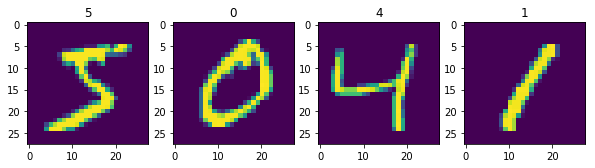

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(x_train[0])
plt.title(label_list[y_train[0]])
plt.subplot(142)
plt.imshow(x_train[1])
plt.title(label_list[y_train[1]])
plt.subplot(143)
plt.imshow(x_train[2])
plt.title(label_list[y_train[2]])
plt.subplot(144)
plt.imshow(x_train[3])
plt.title(label_list[y_train[3]])
plt.show()

# Model

In [7]:
from keras import layers
from keras import models
from keras.preprocessing.image import random_rotation

In [8]:
img_input = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(img_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', use_bias=False)(x)
x = layers.Dense(1024, activation='relu', use_bias=False)(x)
x = layers.Dense(10, activation='softmax', use_bias=False)(x)

model = models.Model(img_input, x)

# Generator

In [9]:
def Generator(x, y,
              mode='train',
              batch_size=128,
              seed=42,
              shuffle=False,
              **kwargs):
    
    datalist = np.arange(x.shape[0])
    batch = 0
    X = np.zeros((batch_size, 28, 28, 1))
    Y = np.zeros((batch_size, 10))
    while True:
        if shuffle:
            random.shuffle(datalist)
            
        for data in datalist:
            img = x[data].astype('float32')
            img = img[...,np.newaxis]
            img /= 255
            
            if mode == 'train':
                img = random_rotation(img, 10, row_axis=0, col_axis=1, channel_axis=2)
                img += np.random.normal(scale=.1)
                
            X[batch] = img
            Y[batch, y[data]] += 1
            
            batch += 1
            if batch >= batch_size:
                yield X, Y
                batch = 0
                X = np.zeros((batch_size, 28, 28, 1))
                Y = np.zeros((batch_size, 10))

# Train

In [10]:
lr = .0001
batch_size = 64
epochs = 1
steps = 2000

In [11]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr, clipnorm=.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [12]:
train_generator = Generator(x=x_train, y=y_train, mode='train', batch_size=batch_size)
val_generator = Generator(x=x_test, y=y_test, mode='validation', batch_size=100, shuffle=False)

In [13]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=int(len(y_test)/100))

Epoch 1/1
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1127 - acc: 0.9670 - val_loss: 0.0762 - val_acc: 0.9794


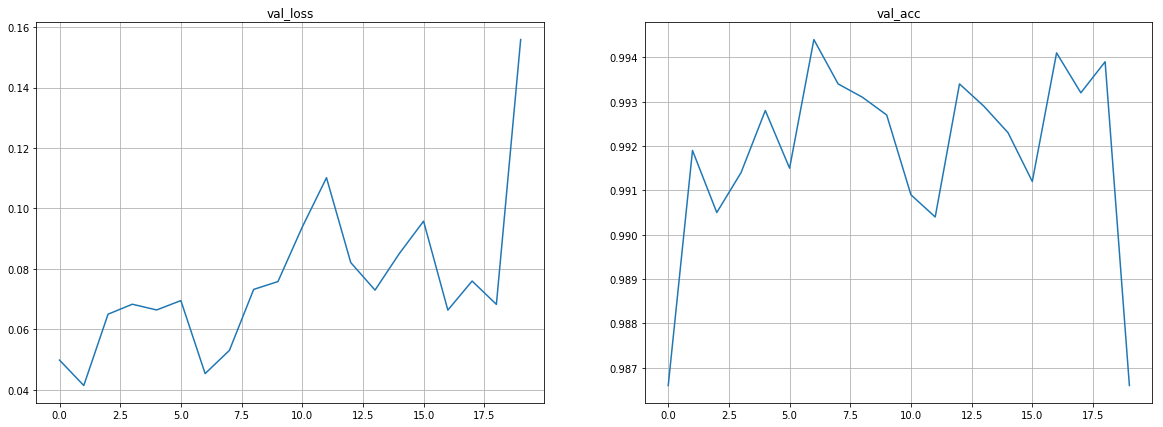

In [30]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('val_loss')
plt.subplot(122)
plt.plot(history.history['val_acc'])
plt.grid()
plt.title('val_acc')
plt.show()

In [14]:
model.save('./mnist.h5')